## House Price Prediction - King County Housing Dataset

This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015.


* id: This is unique identification number given to each house in the dataset.
* date: This is the date the house is added into the dataset and is in the format YYYY-MM-DD.
* price: Price of each house in US dollars.
* bedrooms: Number of bed rooms available in each house and the dataset has houses having number of bedrooms ranging from 0 to 33.
* bathrooms: Number of bed rooms available in each house and the dataset has houses having number of bedrooms ranging from 0 to 8.
* sqft_living: Area size of living room in square feet.
* sqft_lot: Total area of size of lot in square feet.
* floors: Number of floors available in house.
* waterfront: This is an indicator if the house is located on or beside a lake or beach. Possible values are 0 – indicating No and 1 – indicating Yes.
* view: Rating of view of city or lake or beach from house and is rated from 0 to 5.
* condition: Overall condition of house rated in the range 1 to 5.
* grade: Overall grade of house ranging from 1 to 12.
* sqft_above: The surface area of house in square feet above ground level.
* sqft_basement: The surface area of house in square feet below ground level or basement.
* yr_built: The year of house in which it is constructed.
* yr_renovated: Year in which house is renovated or remodeled.
* zipcode: It is a 5 digit zip code in which the house is located.
* lat: Geographical Latitude position of the house.
* long: Geographical longitude position of the house.
* sqft_living15: It is the average house square footage of the 15 closest houses.
* sqft_lot15: It is the average lot square footage of the 15 closest houses.

In [1]:
# importing dependencies here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# for the model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# for feature engineering
from sklearn.preprocessing import StandardScaler
from feature_engine import missing_data_imputers as mdi
from feature_engine import discretisers as dsc
from feature_engine import categorical_encoders as ce

In [2]:
# reading the dataset
df = pd.read_csv("king_county_house_data.csv").drop(["id"], axis=1)

In [3]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


### Data Analysis

In [4]:
# inspecting the variable types
df.dtypes

date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

It is a combination of categorical and numerical (discreate and continuous) variable types in the dataset. Numerical variables are defined as int and float. Categorical variables are defined as object. 

In [5]:
# converting zipcode, lat and long to object type
df = df.astype({"zipcode": str, "lat": str, "long": str})
df["date"] = pd.to_datetime(df["date"])

In [6]:
df.dtypes

date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                  object
lat                      object
long                     object
sqft_living15             int64
sqft_lot15                int64
dtype: object

#### Finding Categorical variables

In [7]:
categorical = [var for var in df.columns if df[var].dtype == 'O' ]
print('There are {} categorical variables'.format(len(categorical)))

There are 3 categorical variables


Currently there is only 1 categorical variable in the dataset and that is date but clearly there seem to be few more variables that should be converted into categorical variables later in this code.

In [8]:
df[categorical].head(2)

,zipcode,lat,long
0,98178,47.5112,-122.257
1,98125,47.721000000000004,-122.319


#### Finding temporal variables
There are a few variables in the dataset that are temporal. They indicate the year in which something happened. We shouldn't use these variables straightaway for model building. We should instead transform them to capture some sort of time information. Let's inspect these temporal variables.

In [9]:
year_vars = [var for var in df.columns if "yr" in var or "Year" in var]
year_vars

['yr_built', 'yr_renovated']

In [10]:
df[year_vars].head(5)

,yr_built,yr_renovated
0,1955,0
1,1951,1991
2,1933,0
3,1965,0
4,1987,0


We have another temporal variable that is Date. Let's see if date is having any impact on the price. 

In [11]:
# extracting month from the date columm and adding it to the dataframe
df["month_sold"] = df["date"].dt.month

# dropping date variable from the dataset
df = df.drop("date", axis=1)

df.head(3)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,10
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.721000000000004,-122.319,1690,7639,12
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.23299999999999,2720,8062,2


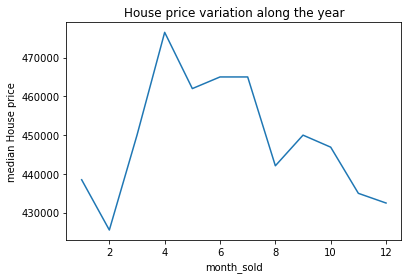

In [12]:
# plotting month and price to find which months have higher house prices
df.groupby("month_sold")["price"].median().plot()
plt.title('House price variation along the year')
plt.ylabel('median House price')
plt.show()

The price seems to vary depending on the month in which the house is sold. We can see that house price is highest in April and lowest in February.

#### Finding discrete variables
To identify discrete variables, I will select from all the numerical ones, those that contain a finite and small number of distinct values.

In [13]:
# let's visualise the values of the discrete variables
discrete = []

numerical = [var for var in df.columns if df[var].dtype != "O"]

for var in numerical:
    if len(df[var].unique()) < 20 and var not in year_vars:
        discrete.append(var)
        print(var, "values", df[var].unique())
        
print(f"\nThere are {len(discrete)} discrete variables in the dataset that have less than 20 unique values.")

bedrooms values [ 3  2  4  5  1  6  7  0  8  9 11 10 33]
floors values [1.  2.  1.5 3.  2.5 3.5]
waterfront values [0 1]
view values [0 3 4 2 1]
condition values [3 5 4 1 2]
grade values [ 7  6  8 11  9  5 10 12  4  3 13  1]
month_sold values [10 12  2  5  6  1  4  3  7  8 11  9]

There are 7 discrete variables in the dataset that have less than 20 unique values.


There seem to be a unusally high number of bedrooms (11 and 33). We will be inspecting it further later in the code.

#### Finding Continuous variables

In [14]:
# finding continuous variables

numerical = [var for var in numerical if var not in discrete and var != "price" and var not in year_vars]

print(f"There are {len(numerical)} continuous (numerical) variables.")
print("\n", numerical)

There are 7 continuous (numerical) variables.

 ['bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']


Number of bathrooms will need further inspection later in the code as it seem to have more than 20 unique values.

In [15]:
df["bathrooms"].unique()

array([1.  , 2.25, 3.  , 2.  , 4.5 , 1.5 , 2.5 , 1.75, 2.75, 3.25, 4.  ,
       3.5 , 0.75, 4.75, 5.  , 4.25, 3.75, 0.  , 1.25, 5.25, 6.  , 0.5 ,
       5.5 , 6.75, 5.75, 8.  , 7.5 , 7.75, 6.25, 6.5 ])

Also, some of these contiuous variables will need encoding since they seem to have high cardinality like zipcode, lat, long.

### Checking for possible problems with the dataset

#### Missing values

In [16]:
df.isnull().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
month_sold       0
dtype: int64

Luckily there are no missing values in the dataset.

#### Outliers and Distributions

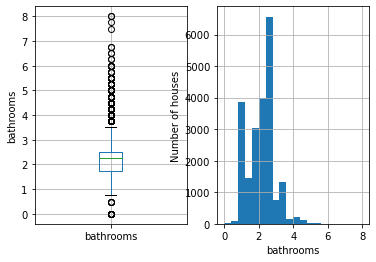

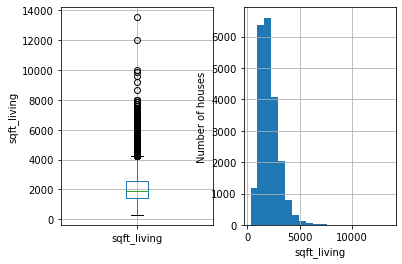

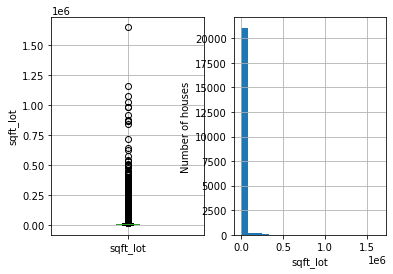

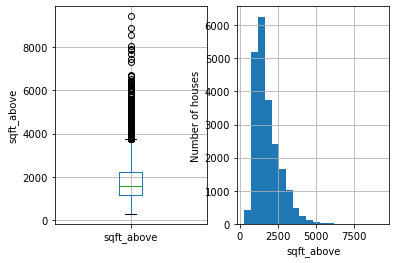

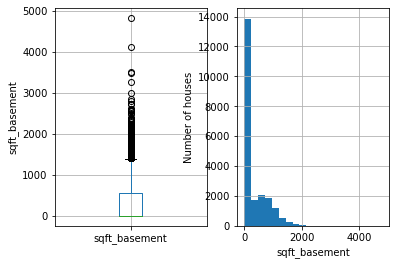

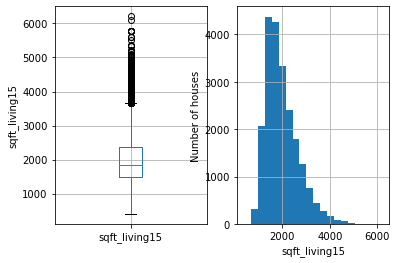

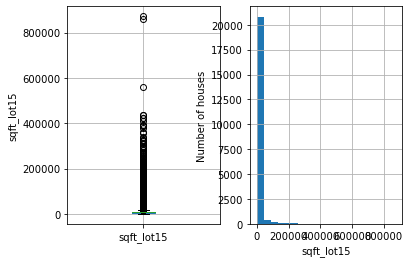

In [17]:
# let's make boxplots to visualise outliers in the continuous variables 
# and histograms to get an idea of the distribution

for var in numerical:
    plt.figure(figsize=(6,4))
    plt.subplot(1, 2, 1)
    fig = df.boxplot(column=var)
    fig.set_title('')
    fig.set_ylabel(var)
    
    plt.subplot(1, 2, 2)
    fig = df[var].hist(bins=20)
    fig.set_ylabel('Number of houses')
    fig.set_xlabel(var)

    plt.show()

The majority of the continuous variables seem to contain outliers. In addition, the majority of the variables are not normally distributed. As we are planning to build linear regression, we need to tackle these to improve the model performance. 

#### Outliers in discrete variables
Now, let's identify outliers in the discrete variables. I will call outliers those values that are present in less than 5 % of the houses. This is exactly the same as finding rare labels in categorical variables. Discrete variables can be pre-processed / engineered as if they were categorical.

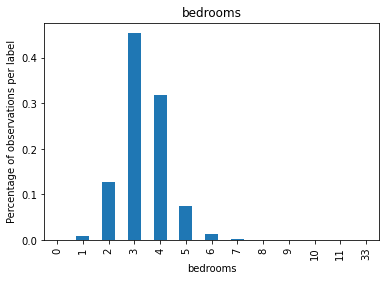

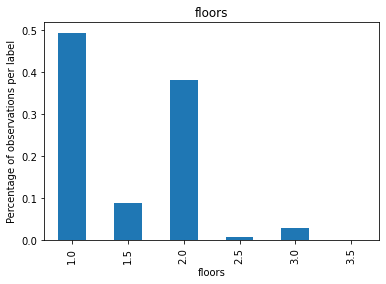

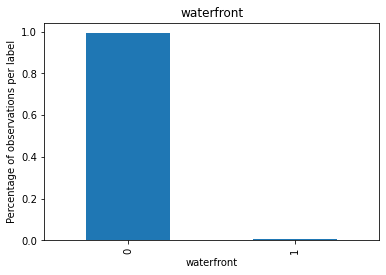

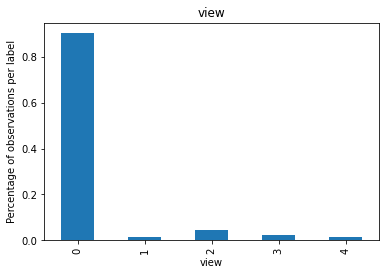

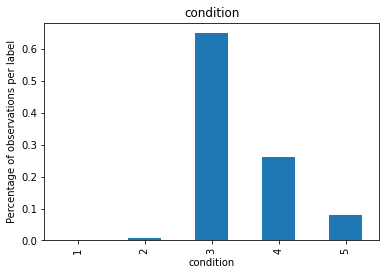

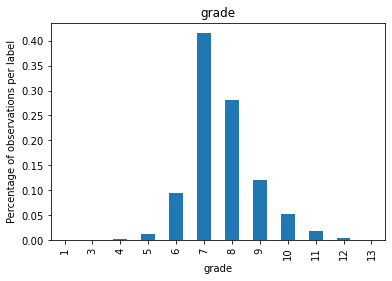

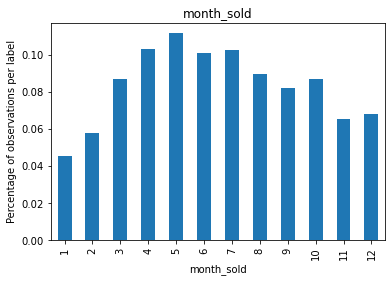

In [18]:
# outliers in discrete variables

for var in discrete:
    (df.groupby(var)[var].count() / np.float(len(df))).plot.bar()
    plt.ylabel('Percentage of observations per label')
    plt.title(var)
    plt.show()

Most of the discrete variables show values that are shared by a tiny proportion of houses in the dataset.

### Monotonicity between discrete variables and target values

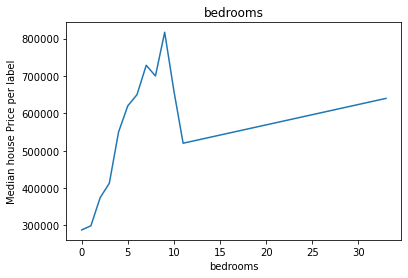

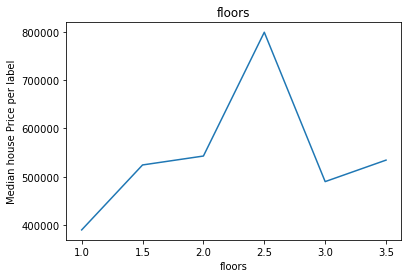

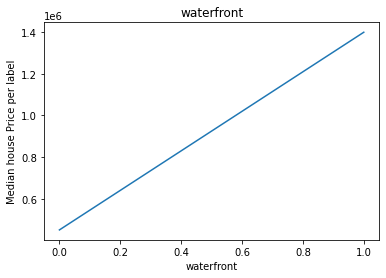

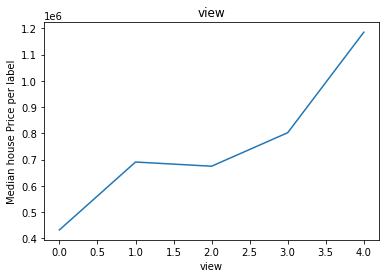

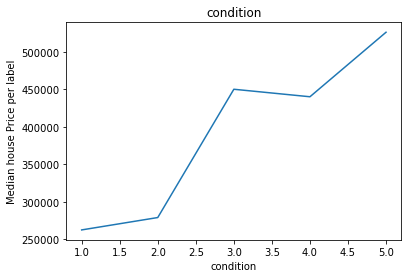

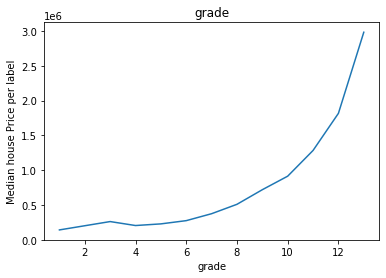

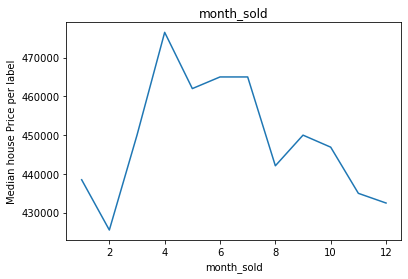

In [19]:
# let's plot the median sale price per value of the discrete
# variable

for var in discrete:
    df.groupby(var)["price"].median().plot()
    plt.ylabel("Median house Price per label")
    plt.title(var)
    plt.show()

Some of the discrete variables show some sort of monotonic relationship and some don't.

#### Number of labels: cardinality
Let's go ahead now and examine the cardinality of our categorical variables. That is, the number of different labels.

Text(0, 0.5, 'Number of different categories')

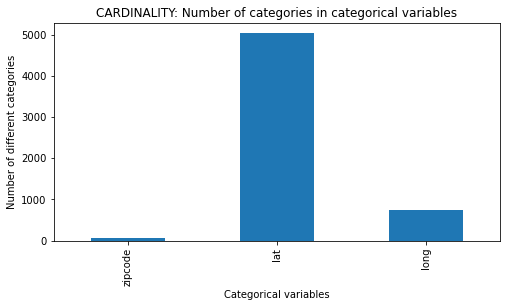

In [20]:
# plot number of categories per categorical variable

df[categorical].nunique().plot.bar(figsize=(8,4))
plt.title("CARDINALITY: Number of categories in categorical variables")
plt.xlabel("Categorical variables")
plt.ylabel("Number of different categories")

In [21]:
# zipcode
df["zipcode"].value_counts().sort_values(ascending=False)

98103    602
98038    590
98115    583
98052    574
98117    553
        ... 
98102    105
98010    100
98024     81
98148     57
98039     50
Name: zipcode, Length: 70, dtype: int64

In [22]:
# zipcode
# df.groupby("zipcode")["zipcode"].value_counts().sort_values(ascending=False).plot(figsize=(15,6))

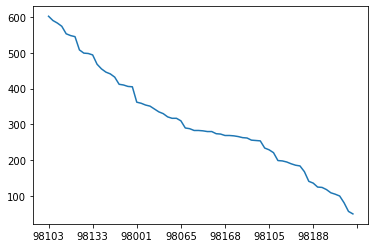

In [23]:
df["zipcode"].value_counts().plot()

In [24]:
# lat
len(df["lat"].unique())

5034

In [25]:
# lat
len(df["long"].unique())

752

We have already converted date into months. Zipcode, lat and long will need encoding for high cardinality.

### Checking for Linear Regression Assumptions

In [26]:
# checking for linear relationship between the features and target variable

# for var in df.columns.values:
#     sns.lmplot(x=var, y="price", data=df)

In [27]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'month_sold'],
      dtype='object')

### Checking for Collinearity

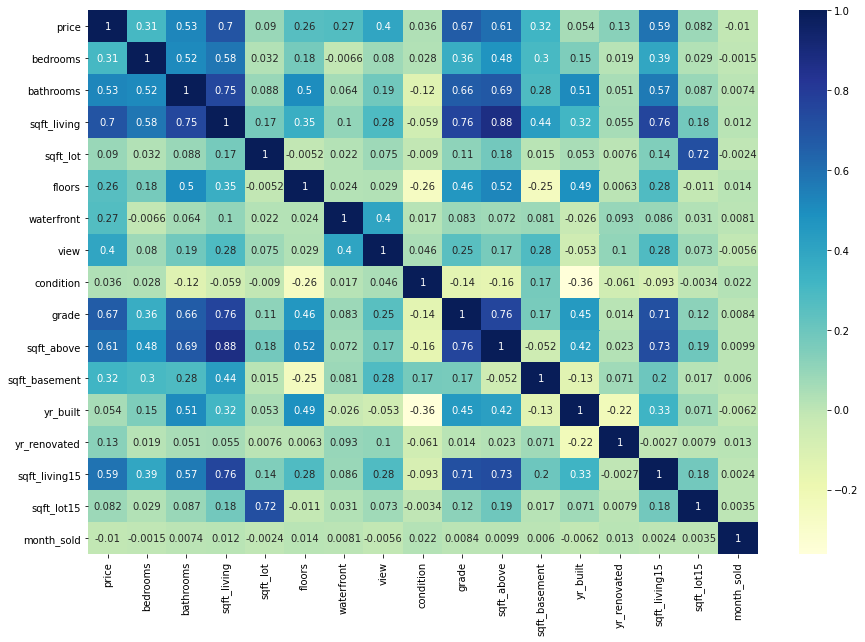

In [28]:
# checking correlation

corr = df.corr()
c1 = corr.abs().unstack()
c1.sort_values(ascending = False)

plt.subplots(figsize=(15,10))
sns.heatmap(corr, annot=True, cmap="YlGnBu")

sqft_living15 seems to have high collinearity with sqft_living and sqft_above.
sqft_lot15 seems to have high collinearity with sqft_lot.
sqft_above seems to have high collinearity with sqft_living.

In [29]:
# dropping some of the collinear sqft variables
df = df.drop(["sqft_living15", "sqft_lot15", "sqft_above"], axis=1)

### Feature Engineering 

Now we will move on and engineer the features of this dataset.

#### Temporal variables 
First, we will create meaningful data from the temporal variables. We have already extracted month from date. Now will will handle yr_built and yr_renovated.

In [30]:
# converting year built into house age
df["age"] = df["yr_built"].apply(lambda x: (2020 - x))

# dropping yr_built
df = df.drop("yr_built", axis=1)

In [31]:
# converting year renovated into renovated/not-renovated (categorical values)
df["yr_renovated"] = df["yr_renovated"].apply(lambda x: "renovated" if x!= 0 else "not-renovated")

In [32]:
df.head(5)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_renovated,zipcode,lat,long,month_sold,age
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,0,not-renovated,98178,47.5112,-122.257,10,65
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,400,renovated,98125,47.721000000000004,-122.319,12,69
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,0,not-renovated,98028,47.7379,-122.23299999999999,2,87
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,910,not-renovated,98136,47.5208,-122.39299999999999,12,55
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,0,not-renovated,98074,47.6168,-122.045,2,33


#### Bedroom - Max bedroom value seems to be unreasonably high, so further exploring it.

In [33]:
df["bedrooms"].value_counts().sort_values(ascending=True)

11       1
33       1
10       3
9        6
8       13
0       13
7       38
1      199
6      272
5     1601
2     2760
4     6882
3     9824
Name: bedrooms, dtype: int64

In [34]:
df[df["bedrooms"] > 10]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_renovated,zipcode,lat,long,month_sold,age
8757,520000.0,11,3.00,3000,4960,2.0,0,0,3,7,600,renovated,98106,47.556000000000004,-122.363,8,102
15870,640000.0,33,1.75,1620,6000,1.0,0,0,5,7,580,not-renovated,98103,47.6878,-122.331,6,73


Dropping rows with greater than 10 bedrooms as sqft_living and sqft_lot for 11 and 33 bedroom houses seem to be less than that of houses with less number of bedrooms. These entries seem to be data entry error and we can safely drop these.

In [35]:
df = df[df["bedrooms"] < 11]

In [36]:
df["bedrooms"].value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      199
7       38
8       13
0       13
9        6
10       3
Name: bedrooms, dtype: int64

#### Converting the discreate variables into object type so that I can apply categorical feature encoding on it.

In [37]:
df.dtypes

price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_basement      int64
yr_renovated      object
zipcode           object
lat               object
long              object
month_sold         int64
age                int64
dtype: object

In [38]:
df[discrete] = df[discrete].astype('O')

In [39]:
df.dtypes

price            float64
bedrooms          object
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors            object
waterfront        object
view              object
condition         object
grade             object
sqft_basement      int64
yr_renovated      object
zipcode           object
lat               object
long              object
month_sold        object
age                int64
dtype: object

In [40]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_renovated,zipcode,lat,long,month_sold,age
0,221900.0,3,1.00,1180,5650,1,0,0,3,7,0,not-renovated,98178,47.5112,-122.257,10,65
1,538000.0,3,2.25,2570,7242,2,0,0,3,7,400,renovated,98125,47.721000000000004,-122.319,12,69
2,180000.0,2,1.00,770,10000,1,0,0,3,6,0,not-renovated,98028,47.7379,-122.23299999999999,2,87
3,604000.0,4,3.00,1960,5000,1,0,0,5,7,910,not-renovated,98136,47.5208,-122.39299999999999,12,55
4,510000.0,3,2.00,1680,8080,1,0,0,3,8,0,not-renovated,98074,47.6168,-122.045,2,33


### ML Models

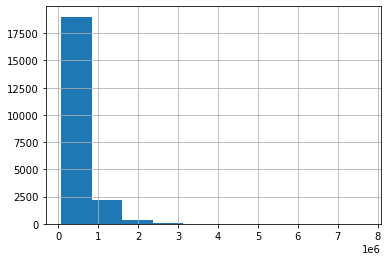

In [41]:
# taking a quick look at the target variable price
df["price"].hist()

Price seems to be highly skewed and will need transformation.

In [42]:
# setting X and y
X = df.drop(["price"], axis=1)
y = np.log(df["price"])

# splitting X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Linear Regression using a Pipeline

In [43]:
# from sklearn.preprocessing import PolynomialFeatures
lr_pipe = Pipeline([

    # categorical encoding
    ('ohe_enc_high_cardinal', ce.OneHotCategoricalEncoder(
        top_categories=30, variables=["zipcode"], drop_last=False)),
    ('ohe_enc_categorical', ce.OneHotCategoricalEncoder(
        top_categories=5, variables=['yr_renovated',
        ])),

    # discretisation + encoding
    ('discretisation', dsc.EqualFrequencyDiscretiser(
        q=5, return_object=True, variables=['bathrooms', 'sqft_living', 'sqft_lot', 'sqft_basement'])),

    # feature Scaling
    ('scaler', StandardScaler()),
    
    # regression
    ('lm', LinearRegression())
])

In [44]:
# fitting the pipeline
lr_pipe.fit(X_train, y_train)

# predictions
y_train_predictions = lr_pipe.predict(X_train)
y_test_predictions = lr_pipe.predict(X_test)

#### Check model Performance

In [45]:
# Train MSE and R2
print(f"Linear Regression Train MSE: {mean_squared_error(y_train, y_train_predictions)}")
print(f"Linear Regression Train R2: {r2_score(y_train, y_train_predictions)}")
print()

# Test MSE and R2
print(f"\nLinear Regression Test MSE: {mean_squared_error(y_test, y_test_predictions)}")
print(f"Linear Regression Test R2: {r2_score(y_test, y_test_predictions)}")

# cross validation score
cv_score = np.mean((cross_val_score(lr_pipe, X, y, cv=5, scoring='neg_mean_squared_error'))*-1)
print("\nCross Validation Score", cv_score)

Linear Regression Train MSE: 0.05500819265332742
Linear Regression Train R2: 0.8014988601482702


Linear Regression Test MSE: 0.05735477740848306
Linear Regression Test R2: 0.7940731738739092

Cross Validation Score 0.05729532482683679


#### Residual Plot for Linear Regression

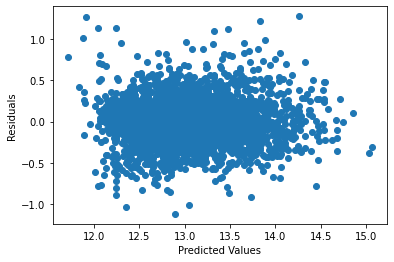

In [46]:
plt.scatter(y_test_predictions, y_test - y_test_predictions)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

#### Q-Q Plot for Linear Regression

Text(0.5, 1.0, 'Normal Q-Q plot')

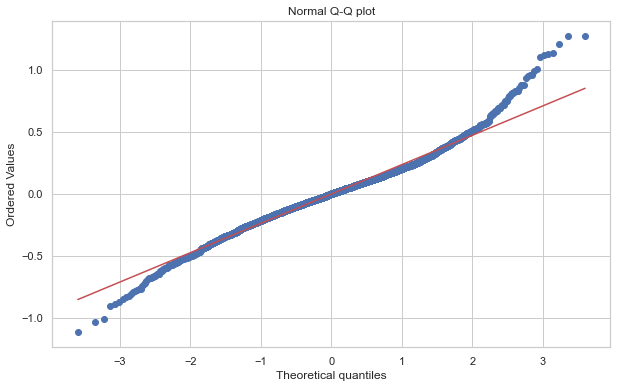

In [47]:
#Normal Q-Q plot
from scipy import stats
sns.set(style="whitegrid")

plt.figure(figsize=(10,6))
stats.probplot(y_test - y_test_predictions, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")

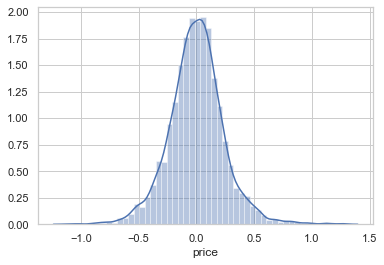

In [48]:
sns.distplot(y_test - y_test_predictions)

### Lasso using Pipeline

In [49]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

lasso_house_pipe = Pipeline([

    # categorical encoding
    ('ohe_enc_high_cardinal', ce.OneHotCategoricalEncoder(
        top_categories=30, variables=["zipcode"], drop_last=False)),
    ('ohe_enc_categorical', ce.OneHotCategoricalEncoder(
        top_categories=5, variables=['yr_renovated',
        ])),

    # discretisation + encoding
    ('discretisation', dsc.EqualFrequencyDiscretiser(
        q=5, return_object=True, variables=['bathrooms', 'sqft_living', 'sqft_lot', 'sqft_basement'])),

    # feature Scaling
    ('scaler', StandardScaler()),
    
    # regression
    ('lg', Lasso())
])

alphas = [1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40]
tuned_parameters = {'lg__alpha': alphas}

lasso_regressor = GridSearchCV(lasso_house_pipe, tuned_parameters, scoring = 'neg_mean_squared_error', cv = 5)

lasso_regressor.fit(X_train, y_train)


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('ohe_enc_high_cardinal',
                                        OneHotCategoricalEncoder(drop_last=False,
                                                                 top_categories=30,
                                                                 variables=['zipcode'])),
                                       ('ohe_enc_categorical',
                                        OneHotCategoricalEncoder(drop_last=False,
                                                                 top_categories=5,
                                                                 variables=['yr_renovated'])),
                                       ('discretisation',
                                        EqualFrequencyDiscretiser(q=5,
                                                                  return_objec...
                                              fit_intercept=True

In [50]:
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)
prediction_lasso = lasso_regressor.predict(X_test)

{'lg__alpha': 1e-15}
-0.05626938082455082


#### Residual Plot for Lasso 

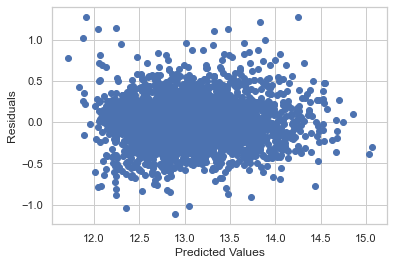

In [51]:
plt.scatter(prediction_lasso, y_test - prediction_lasso)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

#### Q-Q plot for Lasso

Text(0.5, 1.0, 'Normal Q-Q plot')

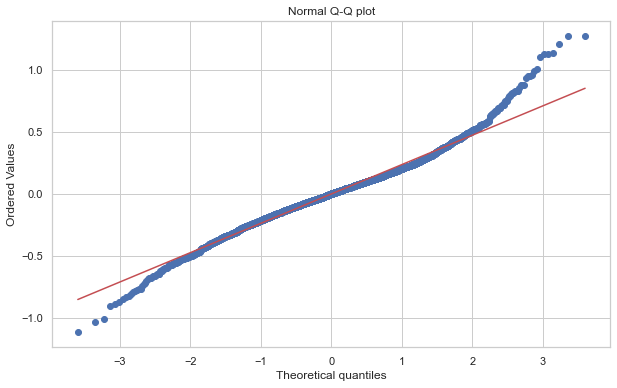

In [52]:
#Normal Q-Q plot
sns.set(style="whitegrid")

plt.figure(figsize=(10,6))
stats.probplot(y_test - prediction_lasso, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")

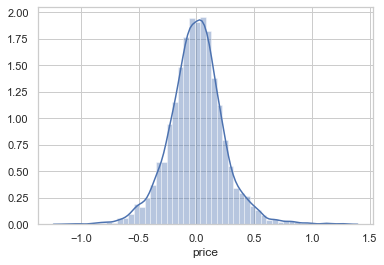

In [53]:
sns.distplot(y_test - prediction_lasso)

#### Check model Performance

In [54]:
# MSE for test data
print('Test MSE:', metrics.mean_squared_error(y_test, prediction_lasso))

# R2 for test data
print("\nCoefficient of determination R^2 <-- on test set:", r2_score(y_test, prediction_lasso))

# cross validation score
cv_score = np.mean((cross_val_score(lasso_regressor, X, y, cv=5, scoring='neg_mean_squared_error'))*-1)
print("\nCross Validation Score", cv_score)

Test MSE: 0.057354499503525475

Coefficient of determination R^2 <-- on test set: 0.7940741716649995

Cross Validation Score 0.0572932098971994


### Random Forest using Pipeline

In [63]:
rf_house_pipe = Pipeline([

    # categorical encoding
    ('ohe_enc_high_cardinal', ce.OneHotCategoricalEncoder(
        top_categories=30, variables=["zipcode"], drop_last=False)),
    ('ohe_enc_categorical', ce.OneHotCategoricalEncoder(
        top_categories=5, variables=['yr_renovated',
        ])),

    # regression
    ('rf', RandomForestRegressor(n_estimators = 100))
])

rf_house_pipe.fit(X_train, y_train)

rf_predictions = rf_house_pipe.predict(X_test)

#### Residual plot for Random Forest 

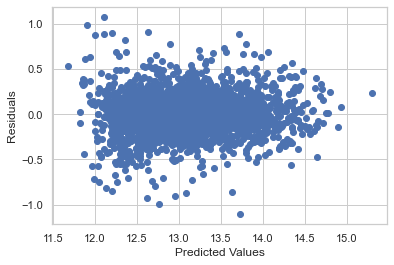

In [64]:
plt.scatter(rf_predictions, y_test - rf_predictions)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

#### Q-Q plot for Random Forest

Text(0.5, 1.0, 'Normal Q-Q plot')

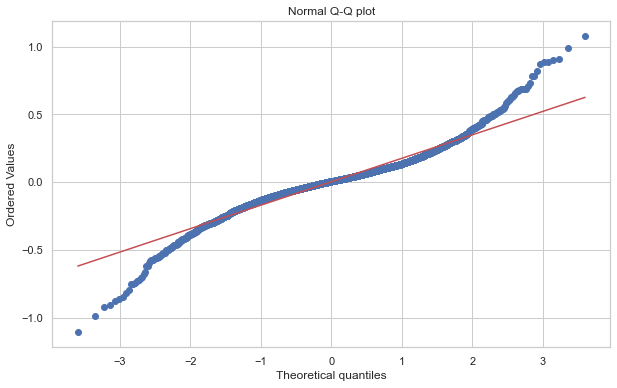

In [65]:
#Normal Q-Q plot
sns.set(style="whitegrid")

plt.figure(figsize=(10,6))
stats.probplot(y_test - rf_predictions, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")

#### Check model Performance

In [62]:
# test MSE
print(f"Test MSE: {metrics.mean_squared_error(y_test, rf_predictions)}")

# test R2
print(f"\nCoefficient of determination R^2 <-- on test set: {rf_house_pipe.score(X_test, y_test)}")

# cross validation score
cv_score = np.mean((cross_val_score(rf_house_pipe, X, y, cv=5, scoring='neg_mean_squared_error'))*-1)
print("\nCross Validation Score", cv_score)

Test MSE: 0.031926122531948896

Coefficient of determination R^2 <-- on test set: 0.8853723197861366

Cross Validation Score 0.030925453748655844


Clearly, Random Forest has the highest Test R2 and lowest Test MSE and CV MSE.